In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
stop = set(stopwords.words('english'))

from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score

demo = True

In [2]:
from kaggle.competitions import twosigmanews
env = twosigmanews.make_env()

Loading the data... This could take a minute.
Done!


In [3]:
(market_train_df, news_train_df) = env.get_training_data()

if demo:
    market_train_df = market_train_df.tail(100000)
    news_train_df = news_train_df.tail(300000)

# Save universe data for latter use
universe = market_train_df['universe']
time = market_train_df['time']


## Feature Engineering

In [4]:
#%%time
# code mostly takes from this kernel: https://www.kaggle.com/ashishpatel26/bird-eye-view-of-two-sigma-xgb

def data_prep(market_df,news_df):
    market_df['time'] = market_df.time.dt.date
    market_df['returnsOpenPrevRaw1_to_volume'] = market_df['returnsOpenPrevRaw1'] / market_df['volume']
    market_df['close_to_open'] = market_df['close'] / market_df['open']
    market_df['volume_to_mean'] = market_df['volume'] / market_df['volume'].mean()
    
    news_df['time'] = news_df.time.dt.hour
    news_df['sourceTimestamp']= news_df.sourceTimestamp.dt.hour
    news_df['firstCreated'] = news_df.firstCreated.dt.date
    news_df['assetCodesLen'] = news_df['assetCodes'].map(lambda x: len(eval(x)))
    news_df['assetCodes'] = news_df['assetCodes'].map(lambda x: list(eval(x))[0])
    news_df['headlineLen'] = news_df['headline'].apply(lambda x: len(x))
    news_df['assetCodesLen'] = news_df['assetCodes'].apply(lambda x: len(x))
    news_df['asset_sentiment_count'] = news_df.groupby(['assetName', 'sentimentClass'])['time'].transform('count')
    news_df['asset_sentence_mean'] = news_df.groupby(['assetName', 'sentenceCount'])['time'].transform('mean')
    lbl = {k: v for v, k in enumerate(news_df['headlineTag'].unique())}
    news_df['headlineTagT'] = news_df['headlineTag'].map(lbl)
    kcol = ['firstCreated', 'assetCodes']
    news_df = news_df.groupby(kcol, as_index=False).mean()

    market_df = pd.merge(market_df, news_df, how='left', left_on=['time', 'assetCode'], 
                            right_on=['firstCreated', 'assetCodes'])

    lbl = {k: v for v, k in enumerate(market_df['assetCode'].unique())}
    market_df['assetCodeT'] = market_df['assetCode'].map(lbl)
    
    market_df = market_df.dropna(axis=0)
    
    return market_df

market_train = data_prep(market_train_df, news_train_df)
print(market_train.shape)
up = market_train.returnsOpenNextMktres10 >= 0

fcol = [c for c in market_train_df.columns if c not in ['assetCode', 'assetCodes', 'assetCodesLen', 'assetName', 'assetCodeT', 'volume_to_mean',
                                             'firstCreated', 'headline', 'headlineTag', 'marketCommentary', 'provider', 'returnsOpenPrevRaw1_to_volume',
                                             'returnsOpenNextMktres10', 'sourceId', 'subjects', 'time', 'time_x', 'universe','sourceTimestamp']]

X = market_train[fcol]#.values
up = up.values
y = market_train.returnsOpenNextMktres10#.values

# Scaling of X values
mins = np.min(X, axis=0)
maxs = np.max(X, axis=0)
rng = maxs - mins
X = 1 - ((maxs - X) / rng)

(17522, 53)


## Modelling

In [32]:
n_train = int(X.shape[0] * 0.8)

X_train, y_train = X.iloc[:n_train], y.iloc[:n_train]
X_valid, y_valid = X.iloc[n_train:], y.iloc[n_train:]

In [33]:
# For valid data, keep only those with universe > 0. This will help calculate the metric
u_valid = (universe.iloc[n_train:] > 0)
t_valid = time.iloc[n_train:]

# u_valid
# X_valid = X_valid[u_valid]
# y_valid = y_valid[u_valid]
# t_valid = t_valid[u_valid]
# del u_valid

In [34]:
# Creat lgb datasets
train_cols = X.columns.tolist()
categorical_cols = [] # ['assetCode', 'assetName', 'dayofweek', 'month']

# Note: y data is expected to be a pandas Series, as we will use its group_by function in `sigma_score`
dtrain = lgb.Dataset(X_train.values, y_train, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)
dvalid = lgb.Dataset(X_valid.values, y_valid, feature_name=train_cols, categorical_feature=categorical_cols, free_raw_data=False)

In [35]:
# We will 'inject' an extra parameter in order to have access to df_valid['time'] inside sigma_score without globals
dvalid.params = {
    'extra_time': t_valid.factorize()[0]
}

In [58]:
lgb_params = dict(
    objective = 'regression_l1',
    learning_rate = 0.1,
    num_leaves = 127,
    max_depth = -1,
#     min_data_in_leaf = 1000,
#     min_sum_hessian_in_leaf = 10,
    bagging_fraction = 0.75,
    bagging_freq = 2,
    feature_fraction = 0.5,
    lambda_l1 = 0.0,
    lambda_l2 = 1.0,
#     metric = 'None', # This will ignore the loss objetive and use sigma_score instead,
    seed = 42 # Change for better luck! :)
)

def sigma_score(preds, valid_data):
    df_time = valid_data.params['extra_time']
    labels = valid_data.get_label()
    
#    assert len(labels) == len(df_time)

    x_t = preds * labels # * df_valid['universe'] # -> Here we take out the 'universe' term because we already keep only those equals to 1.
    
    # Here we take advantage of the fact that `labels` (used to calculate `x_t`)
    # is a pd.Series and call `group_by`
    x_t_sum = x_t.groupby(df_time).sum()
    score = x_t_sum.mean() / x_t_sum.std()

    return 'sigma_score', score, True

evals_result = {}
m = lgb.train(lgb_params, dtrain, num_boost_round=1000, valid_sets=(dvalid,), valid_names=('valid',), verbose_eval=25,
              early_stopping_rounds=100, 
#               feval=sigma_score, 
              evals_result=evals_result)


df_result = pd.DataFrame(evals_result['valid'])

/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 100 rounds.
[25]	valid's l1: 0.0394731
[50]	valid's l1: 0.0411641
[75]	valid's l1: 0.0418501
[100]	valid's l1: 0.0421622
Early stopping, best iteration is:
[1]	valid's l1: 0.0355719


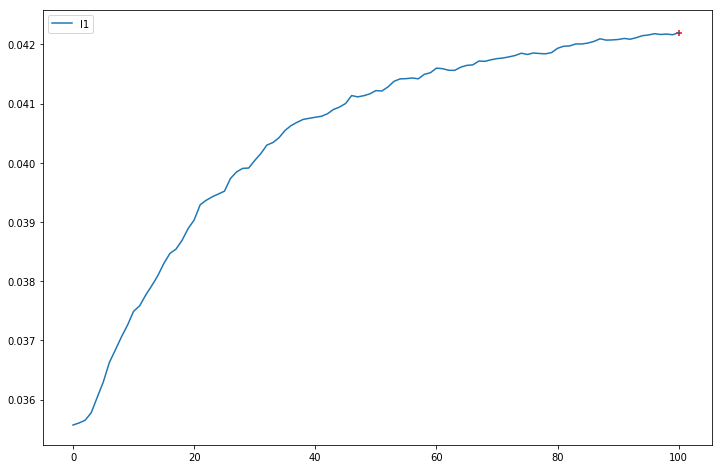

In [51]:
ax = df_result.plot(figsize=(12, 8))
ax.scatter(df_result['l1'].idxmax(), df_result['l1'].max(), marker='+', color='red')

In [50]:
num_boost_round, valid_score = df_result['l1'].idxmax()+1, df_result['l1'].max()
print(lgb_params)
print(f'Best score was {valid_score:.5f} on round {num_boost_round}')

{'objective': 'regression_l1', 'learning_rate': 0.1, 'num_leaves': 127, 'max_depth': -1, 'bagging_fraction': 0.75, 'bagging_freq': 2, 'feature_fraction': 0.5, 'lambda_l1': 0.0, 'lambda_l2': 1.0, 'seed': 42}
Best score was 0.04220 on round 101


## Feature Importance

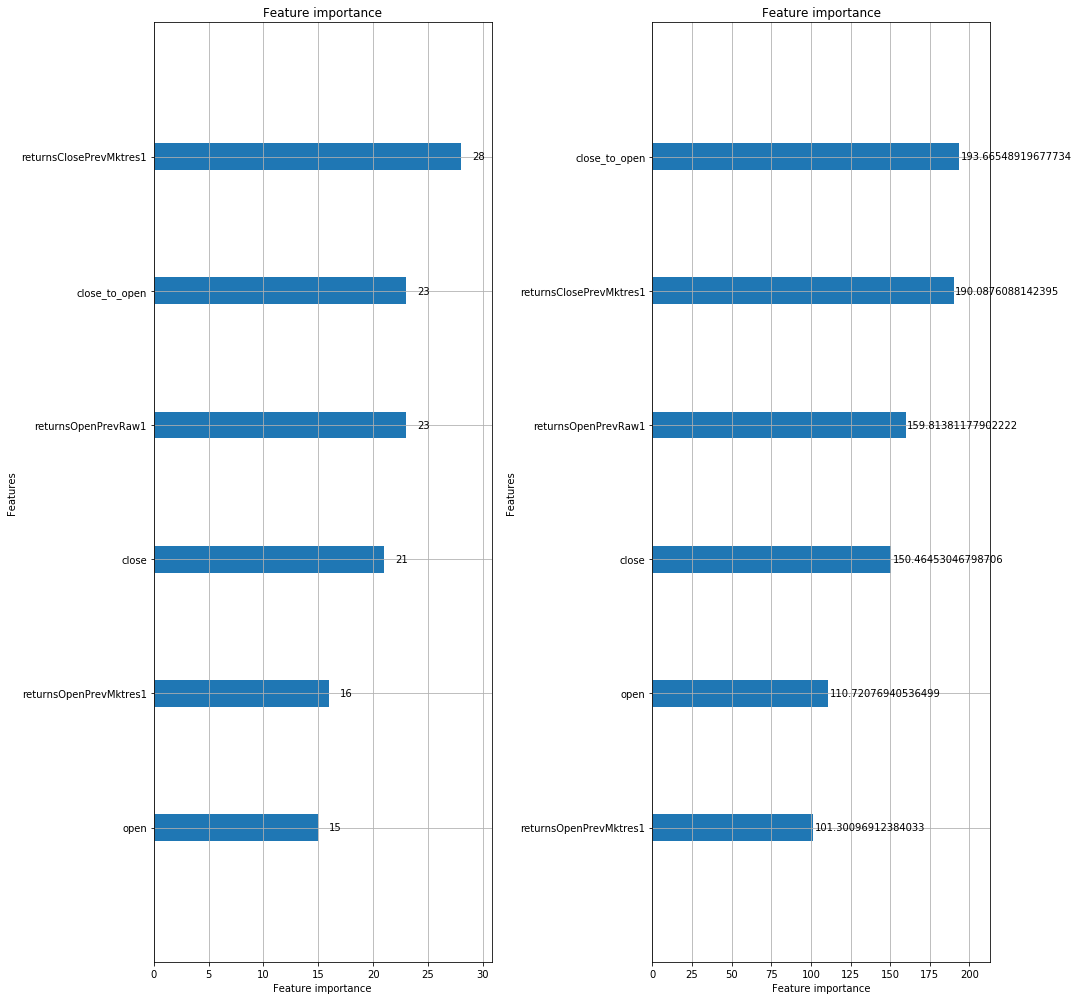

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14, 14))
lgb.plot_importance(m, ax=ax[0])
lgb.plot_importance(m, ax=ax[1], importance_type='gain')
fig.tight_layout()

## Predictions

In [ ]:
days = env.get_prediction_days()
import time

n_days = 0
prep_time = 0
prediction_time = 0
packaging_time = 0
for (market_obs_df, news_obs_df, predictions_template_df) in days:
    n_days +=1
    if n_days % 50 == 0:
        print(n_days,end=' ')
    
    t = time.time()
    market_obs_df = data_prep(market_obs_df, news_obs_df)
    market_obs_df = market_obs_df[market_obs_df.assetCode.isin(predictions_template_df.assetCode)]
    X_live = market_obs_df[fcol].values
    X_live = 1 - ((maxs - X_live) / rng)
    prep_time += time.time() - t
    
    t = time.time()
    lp = xgb_up.predict_proba(X_live)
    prediction_time += time.time() -t
    
    t = time.time()
    confidence = 2* lp[:,1] -1
    preds = pd.DataFrame({'assetCode':market_obs_df['assetCode'],'confidence':confidence})
    predictions_template_df = predictions_template_df.merge(preds,how='left').drop('confidenceValue',axis=1).fillna(0).rename(columns={'confidence':'confidenceValue'})
    env.predict(predictions_template_df)
    packaging_time += time.time() - t
    
# env.write_submission_file()